In [1]:
import sys
# add the parent directory to the path so we can import circuits
current_dir = "/root/chess-gpt-circuits/"
sys.path.append(current_dir)

import os
from circuits.dictionary_learning.dictionary import AutoEncoder
import pickle
import torch as t
# from circuits.chess_utils import decode_list
from IPython.display import HTML
from circuits.chess_utils import pgn_string_to_board
from huggingface_hub import hf_hub_download
from circuits.utils import (
    chess_hf_dataset_to_generator,
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

# download data from huggingface if needed
if not os.path.exists('chess_layer5'):
    hf_hub_download(repo_id='adamkarvonen/chess_saes', filename='chess_layer5.zip', local_dir='circuits')
    # unzip the data
    os.system('unzip circuits/chess_layer5.zip')


device = 'cuda:0'

/root/chess-gpt-circuits/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load SAE
ae_path = 'chess_layer5/ef=4_lr=1e-03_l1=1e-01_layer=5'
ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')

# load information about features
with open(os.path.join(ae_path, 'indexing_find_dots_indices_n_inputs_10000_results_feature_labels.pkl'), 'rb') as f:
    results = pickle.load(f)

def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}
results = to_device(results)



# load model
layer = 5
othello = False
# Note: change total_num_datapoints if you want more/less data
total_num_datapoints = 5000
context_length = 256
batch_size = 32


if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    dataset_name = "adamkarvonen/chess_sae_text"
    data = chess_hf_dataset_to_generator(
        dataset_name, meta, context_length=context_length, split="train", streaming=True
    )
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    dataset_name = "taufeeque/othellogpt"
    data = othello_hf_dataset_to_generator(
        dataset_name, context_length=context_length, split="train", streaming=True
    )
    model_type = "othello"

# model = get_model(model_name, device)
model_b = get_model(model_name, device)
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
submodule = get_submodule(model_name, layer, model)
activation_name = f"transformer.h.{layer}" 
# model

/root/chess-gpt-circuits/logan/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Load Dataset


In [3]:
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        tokens = torch.tensor(item['tokens'], dtype=torch.long)
        return tokens
# Function to tokenize, pad, and convert to tensor
def tokenize_pad_tensorize(text):
    tokens = [meta["stoi"].get(char, 0) for char in text[:context_length]]
    if len(tokens) < context_length:
        tokens.extend([0] * (context_length - len(tokens)))
    return {'tokens': torch.tensor(tokens, dtype=torch.long)}

dataset_name = "adamkarvonen/chess_sae_text"
print(f"Downloading {dataset_name}")
print(f"Caching features activations for {total_num_datapoints} games")
print(f"Total num of tokens: {total_num_datapoints*context_length}")

dataset = load_dataset(dataset_name, split=f"train[:{total_num_datapoints}]").map(
    lambda x: tokenize_pad_tensorize(x['text'])
)

Caching features activations for 5000 games
Total num of tokens: 1280000


Map: 100%|██████████| 5000/5000 [00:01<00:00, 4863.45 examples/s]


In [4]:

batch_size = 32
# Create the PyTorch dataset and DataLoader
torch_dataset = CustomDataset(dataset)
dataloader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=False)

# Example of iterating over the DataLoader
for batch in dataloader:
    print(torch.tensor(batch).shape)
    break

torch.Size([32, 256])


/tmp/ipykernel_36568/1557768176.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(batch).shape)


# Interp Definitions

In [5]:
# dkfimport torch
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from baukit import Trace
import numpy as np

def get_dictionary_activations(model, dl, cache_name, max_seq_length, autoencoder, total_num_datapoints):
    num_features, d_model = autoencoder.encoder.weight.shape
    batch_size = dl.batch_size
    dictionary_activations = torch.zeros((total_num_datapoints*max_seq_length, num_features))
    token_list = torch.zeros((total_num_datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dl)):
            batch = torch.tensor(batch).to(model.device)
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            with Trace(model, cache_name) as ret:
                _ = model(batch).logits
                internal_activations = ret.output
                # check if instance tuple
                if(isinstance(internal_activations, tuple)):
                    internal_activations = internal_activations[0]
            batched_neuron_activations = rearrange(internal_activations, "b s n -> (b s) n" )
            batched_dictionary_activations = autoencoder.encode(batched_neuron_activations)
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list



def get_autoencoder_activation(model, cache_name, tokens, autoencoder):
    device = model.device
    with Trace(model, cache_name) as ret, torch.no_grad():
        _ = model(tokens.to(device))
        internal_activations = ret.output
        # check if instance tuple
        if(isinstance(internal_activations, tuple)):
            internal_activations = internal_activations[0]
    internal_activations = rearrange(internal_activations, "b s n -> (b s) n" )
    autoencoder_activations = autoencoder.encode(internal_activations)
    return autoencoder_activations


def get_feature_datapoints(found_indices, best_feature_activations, tokenizer, max_seq_length, dataset):
    num_datapoints = dataset.num_rows
    datapoint_indices =[np.unravel_index(i, (num_datapoints, max_seq_length)) for i in found_indices]
    all_activations = best_feature_activations.reshape(num_datapoints, max_seq_length).tolist()
    full_activations = []
    partial_activations = []
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for i, (md, s_ind) in enumerate(datapoint_indices):
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["tokens"])
        # return full_tok
        # full_text.append(tokenizer.decode(full_tok))
        # print(full_tok)
        full_text.append([tokenizer["itos"][to] for to in full_tok.tolist()])
        tok = dataset[md]["tokens"][:s_ind+1]
        full_activations.append(all_activations[md])
        partial_activations.append(all_activations[md][:s_ind+1])
        # text = tokenizer.decode(tok)
        # print(tok)
        text = [tokenizer["itos"][to] for to in tok]
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, partial_activations, full_activations

def convert_token_array_to_list(array):
    if isinstance(array, torch.Tensor):
        if array.dim() == 1:
            array = [array.tolist()]
        elif array.dim()==2:
            array = array.tolist()
        else: 
            raise NotImplementedError("tokens must be 1 or 2 dimensional")
    elif isinstance(array, list):
        # ensure it's a list of lists
        if isinstance(array[0], int):
            array = [array]
    return array

def make_colorbar(min_value, max_value, white = 255, red_blue_ness = 250, positive_threshold = 0.01, negative_threshold = 0.01):
    # Add color bar
    colorbar = ""
    num_colors = 4
    if(min_value < -negative_threshold):
        for i in range(num_colors, 0, -1):
            ratio = i / (num_colors)
            value = round((min_value*ratio),1)
            text_color = "255,255,255" if ratio > 0.5 else "0,0,0"
            colorbar += f'<span style="background-color:rgba(255, {int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},1); color:rgb({text_color})">&nbsp{value}&nbsp</span>'
    # Do zero
    colorbar += f'<span style="background-color:rgba({white},{white},{white},1);color:rgb(0,0,0)">&nbsp0.0&nbsp</span>'
    # Do positive
    if(max_value > positive_threshold):
        for i in range(1, num_colors+1):
            ratio = i / (num_colors)
            value = round((max_value*ratio),1)
            text_color = "255,255,255" if ratio > 0.5 else "0,0,0"
            colorbar += f'<span style="background-color:rgba({int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},255,1);color:rgb({text_color})">&nbsp{value}&nbsp</span>'
    return colorbar


def value_to_color(activation, max_value, min_value, white = 255, red_blue_ness = 250, positive_threshold = 0.01, negative_threshold = 0.01):
    if activation > positive_threshold:
        ratio = activation/max_value
        text_color = "0,0,0" if ratio <= 0.5 else "255,255,255"  
        background_color = f'rgba({int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},255,1)'
    elif activation < -negative_threshold:
        ratio = activation/min_value
        text_color = "0,0,0" if ratio <= 0.5 else "255,255,255"  
        background_color = f'rgba(255, {int(red_blue_ness-(red_blue_ness*ratio))},{int(red_blue_ness-(red_blue_ness*ratio))},1)'
    else:
        text_color = "0,0,0"
        background_color = f'rgba({white},{white},{white},1)'
    return text_color, background_color

def tokens_and_activations_to_html(toks, activations, tokenizer, logit_diffs=None, model_type="causal", activation_text = "Token Activations: "):
    # text_spacing = "0.07em"
    text_spacing = "0.00em"
    toks = convert_token_array_to_list(toks)
    activations = convert_token_array_to_list(activations)
    # toks = [[tokenizer.decode(t).replace('Ġ', '&nbsp').replace('\n', '↵') for t in tok] for tok in toks]
    # toks = [[t.replace('Ġ', '&nbsp').replace('\n', '\\n') for t in tok] for tok in toks]
    header_text = []
    highlighted_text = []
    board_states = []
    # Make background black
    # header_text.append('<body style="background-color:black; color: white;">')
    header_text.append("""
<body style="background-color: black; color: white;">
""")
    max_value = max([max(activ) for activ in activations])
    min_value = min([min(activ) for activ in activations])
    if(logit_diffs is not None and model_type != "reward_model"):
        logit_max_value = max([max(activ) for activ in logit_diffs])
        logit_min_value = min([min(activ) for activ in logit_diffs])

    # Add color bar
    header_text.append(activation_text + make_colorbar(min_value, max_value))
    if(logit_diffs is not None and model_type != "reward_model"):
        header_text.append('<div style="margin-top: 0.1em;"></div>')
        header_text.append("Logit Diff: " + make_colorbar(logit_min_value, logit_max_value))
    


    header_text.append('<div style="margin-top: 0.5em;"></div>')
    for seq_ind, (act, tok) in enumerate(zip(activations, toks)):
        tmp_text = []
        for act_ind, (a, t) in enumerate(zip(act, tok)):
            if(logit_diffs is not None and model_type != "reward_model"):
                tmp_text.append('<div style="display: inline-block;">')
            text_color, background_color = value_to_color(a, max_value, min_value)
            tmp_text.append(f'<span style="background-color:{background_color};margin-right: {text_spacing}; color:rgb({text_color})">{t.replace(" ", "&nbsp")}</span>')
            if(logit_diffs is not None and model_type != "reward_model"):
                logit_diffs_act = logit_diffs[seq_ind][act_ind]
                _, logit_background_color = value_to_color(logit_diffs_act, logit_max_value, logit_min_value)
                tmp_text.append(f'<div style="display: block; margin-right: {text_spacing}; height: 10px; background-color:{logit_background_color}; text-align: center;"></div></div>')
        if(logit_diffs is not None and model_type=="reward_model"):
            reward_change = logit_diffs[seq_ind].item()
            text_color, background_color = value_to_color(reward_change, 10, -10)
            tmp_text.append(f'<br><span>Reward: </span><span style="background-color:{background_color};margin-right: {text_spacing}; color:rgb({text_color})">{reward_change:.2f}</span>')
        tmp_text.append('<div style="margin-top: 0.2em;"></div>')
        highlighted_text.append(''.join(tmp_text))
        pgn_string = ''.join(tok)
        while pgn_string:
            try:
                board_states.append(pgn_string_to_board(pgn_string))
                break
            except:
                pgn_string = pgn_string[:-1]
        # highlighted_text.append('<br><br>')
    # highlighted_text.append('</body>')
    # highlighted_text = ''.join(highlighted_text)
    header_text = ''.join(header_text)
    return header_text, highlighted_text, board_states


def get_feature_indices(feature_index, dictionary_activations, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    return found_indices

    
def ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature, batch_size=32, setting="full_dataset", model_type="causal"):
    device = model.device

    
    def sae_ablation(x, features, sae):
        # affine ablate all sae features up to their bias-component
        # This is iterative, so we remove each feature component one by one
        # This is to avoid double-subtracting directions that features have in common

        # baukit nonsense to handle both residual stream & mlp/attn_output
        if(isinstance(x, tuple)):
            second_value = x[1]
            internal_activation = x[0]
        else:
            internal_activation = x
        batch, seq_len, hidden_size = internal_activation.shape
        int_val = rearrange(internal_activation, "b seq d_model -> (b seq) d_model")
        
        # Encode in features, then remove all features
        f = sae.encode(int_val)
        residual = int_val - sae.decode(f)
        # set f of ablation to zero tensor
        f[..., features] = 0

        x_hat = sae.decode(f)
        x_recon = residual + x_hat

        # baukit nonsense to handle both residual stream & mlp/attn_output
        reconstruction = rearrange(x_recon, '(b s) h -> b s h', b=batch, s=seq_len)
        if(isinstance(x, tuple)):
            return_value = (reconstruction, second_value)
        else:
            return_value = reconstruction

        return return_value


def ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20):
    all_changed_activations = []
    for token_ind, token_l in enumerate(dataset):
    # for token_ind, token_l in enumerate(full_token_list):
        seq_size = len(token_l)
        original_activation = get_autoencoder_activation(model, cache_name, torch.tensor(token_l).unsqueeze(0), autoencoder)
        original_activation = original_activation[-1,feature].item()
        # Run through the model for each seq length
        if(seq_size==1):
            continue # Size 1 sequences don't have any context to ablate
        # changed_activations = torch.zeros(seq_size).cpu() + original_activation
        changed_activations = torch.zeros(seq_size).cpu()
        minimum_seq_length = max(1, seq_size-max_ablation_length)
        for i in range(minimum_seq_length, seq_size-1):
            ablated_tokens = token_l[:i] + token_l[i+1:]
            # ablated_tokens = token_l
            ablated_tokens = torch.tensor(ablated_tokens).unsqueeze(0)
            with torch.no_grad():
                dictionary_activations = get_autoencoder_activation(model, cache_name, ablated_tokens, autoencoder)
                changed_activations[i] = dictionary_activations[-1,feature].item()
        # changed_activations -= original_activation
        changed_activations[minimum_seq_length:] -= original_activation
        all_changed_activations.append(changed_activations.tolist())
    return all_changed_activations

def feature_display(feature, dictionary_activations, ablate_context=False, logit_lens=False, setting="max", num_feature_datapoints=10):


    if(logit_lens):
        num_tokens_to_look_at = 3
        feature_vector = ae.decoder.weight.data[:, feature]
        logit_lens = model.lm_head(feature_vector)
        tok_val, tok_ind = logit_lens.topk(num_tokens_to_look_at, largest=True)
        [meta["itos"][tok] for tok in tok_ind.tolist()], tok_val.tolist()
        print("logit_lens")
        print("Most promoted:")
        for ind, val in zip(tok_ind.tolist(), tok_val.tolist()):
            print(f"{meta['itos'][ind]}: {val:.2f}")
        tok_val, tok_ind = logit_lens.topk(num_tokens_to_look_at, largest=False)
        print("Least tokens")
        for ind, val in zip(tok_ind.tolist(), tok_val.tolist()):
            print(f"{meta['itos'][ind]}: {val:.2f}")

    text_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting=setting)
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations =  get_feature_datapoints(text_indices, dictionary_activations[:, feature], meta, context_length, dataset)
    logit_diffs = ablate_feature_direction(model, full_token_list, activation_name, context_length, ae, feature = feature, batch_size=batch_size, setting="sentences", model_type="causal")

    # html = tokens_and_activations_to_html(full_text, full_activations, meta, logit_diffs=logit_diffs)
    header_text, highlighted_text, board_states = tokens_and_activations_to_html(full_text, full_activations, meta, logit_diffs=logit_diffs)
    # header_text, highlighted_text, board_states  = tokens_and_activations_to_html(text_list, partial_activations, meta, logit_diffs=logit_diffs)
    if(ablate_context):
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, activation_name, ae, feature, max_ablation_length=10)
        header_text_ablated, highlighted_text_ablated, _ = tokens_and_activations_to_html(text_list, all_changed_activations, meta, activation_text = "Ablated: ")

    display(HTML(header_text))
    if(ablate_context):
        display(HTML(header_text_ablated))
    for text_ind in range(len(highlighted_text)):
        highlight = highlighted_text[text_ind]
        display(HTML(highlight))
        # Ablated context
        if(ablate_context):
            highlight_ablated = highlighted_text_ablated[text_ind]
            display(HTML(highlight_ablated))
        # Board state    
        pgn_string = "".join(text_list[text_ind])
        while pgn_string:
            try:
                display(pgn_string_to_board(pgn_string))
                break
            except:
                pgn_string = pgn_string[:-1]

# Feature Display
First cache activations for all features over our dataset
Note: If your kernel crashes, you loaded too large of the dataset. Change total_num_datapoints to lower

In [6]:
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataloader, activation_name, context_length, ae, total_num_datapoints)

  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_36568/1762572759.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch).to(model.device)
100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


logit_lens
Most promoted:
9: 0.11
3: 0.10
#: 0.09
Least tokens
N: -0.07
6: -0.05
8: -0.04


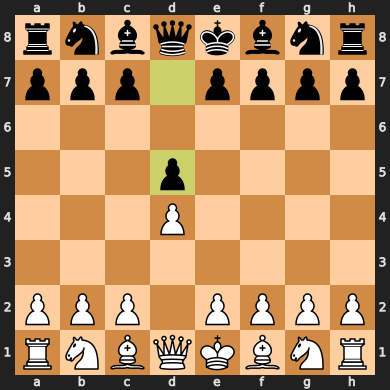

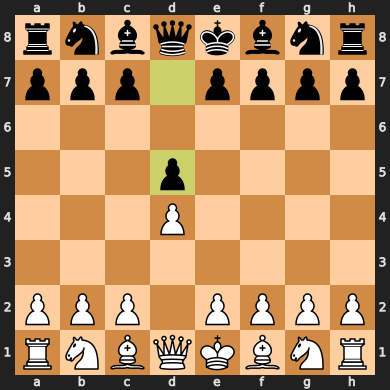

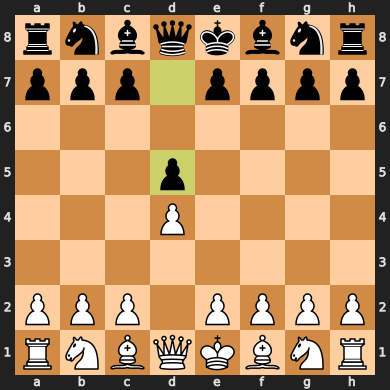

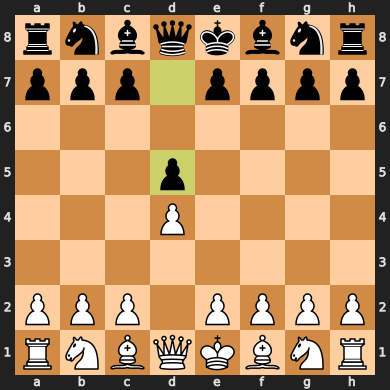

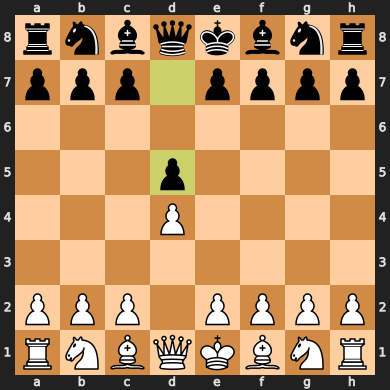

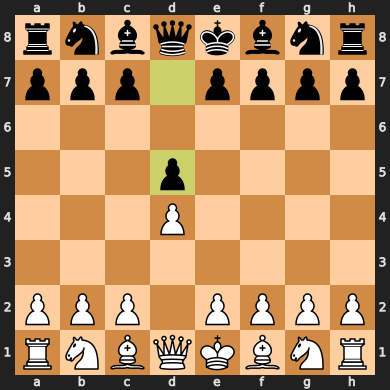

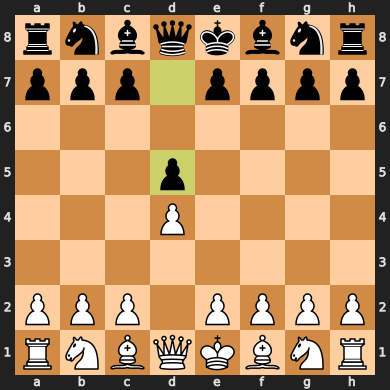

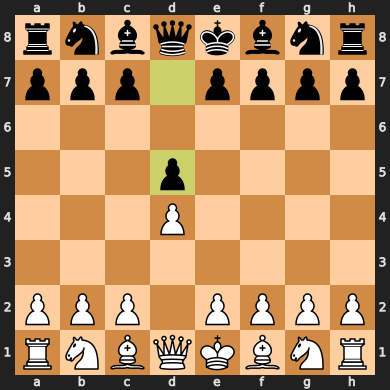

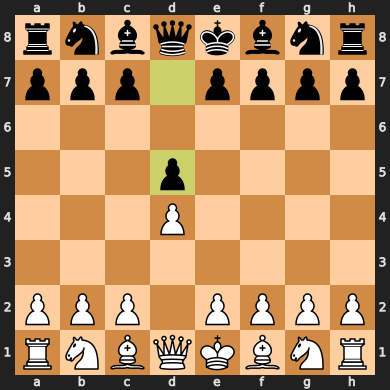

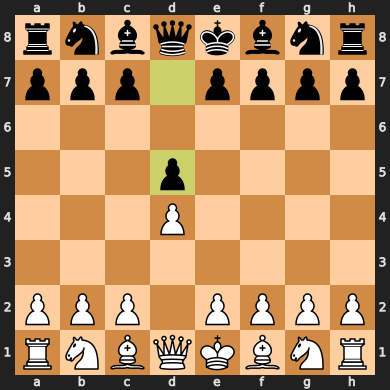

In [11]:
feature = 3
num_feature_datapoints = 10
ablate_context=True
logit_lens = True
# setting = "uniform"
setting = "max"

feature_display(feature, dictionary_activations, ablate_context=ablate_context, logit_lens=logit_lens, setting=setting, num_feature_datapoints=num_feature_datapoints)

# Custom Feature Search

In [30]:
# text = ";1.d4 d5 2.c4 c6 3.cxd5 cxd5 4.Nc3 Nc6 5.e4 dxe4 6.d5 Ne5 7.Qa4+ Bd7 8.Qxe4 Qc7 9.Bf4 f6 10.Nf3 Nxf3+ 11.Qxf3 Qb6 "
#TODO: Make this work as a list
text = ";1.b3 Nf6 2.Bb2 g6 3.d3 Bg7 4.Nd2 O-O 5.e3 d5 6.c4 c5 7.cxd5 Nxd5 8.d4 Nc6 9.Qc2 cxd4 10.exd4 Nxd4 "
tokens = [meta["stoi"][char] for char in text]
tokens = torch.tensor(tokens).unsqueeze(0)
dict_act = get_autoencoder_activation(model, activation_name, tokens, ae)
pgn_string = text
text_list = [[meta["itos"][tok] for tok in tokens[0].tolist()]]
feature_act = [dict_act[:, feature].tolist()]
# num_feature_datapoints = 10
# setting="max"
# text_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting=setting)
# text_list, full_text, token_list, full_token_list, partial_activations, full_activations =  get_feature_datapoints(text_indices, dictionary_activations[:, feature], meta, context_length, dataset)
# # logit_diffs = ablate_feature_direction(model, full_token_list, activation_name, context_length, ae, feature = feature, batch_size=batch_size, setting="sentences", model_type="causal")
# text_list
header, highlights, _ = tokens_and_activations_to_html(text_list, feature_act, meta)
# header_text, highlighted_text, board_states = tokens_and_activations_to_html(full_text, full_activations, meta, logit_diffs=logit_diffs)


# while pgn_string:
#     try:
#         display(pgn_string_to_board(pgn_string))
#         break
#     except:
#         pgn_string = pgn_string[:-1]
display(HTML(header))
for high in highlights:
    display(HTML(high))